# Artificial Intelligence of Things - Demonstration

This document describes methods and mechanisms for the execution of
Artificial Neural Networks in devices with low computational power.

## Load dataset

In [1]:
import src.dataset.yalefaces as yalefaces
import numpy as np

np.random.seed(99)

In [2]:
import numpy as np
X, y = yalefaces.load("data/yalefaces", flatten=True)
X = X.astype("float32") / 255.0

print(f"Loaded {int(X.shape[0]/len(np.unique(y)))} faces from {len(np.unique(y))} individuals,"
f" a total of {X.shape[0]} images of size {yalefaces.SHAPE} ({X[0].shape[0]} pixels).")

Loaded 11 faces from 15 individuals, a total of 165 images of size (243, 320) (77760 pixels).


<Figure size 640x480 with 0 Axes>

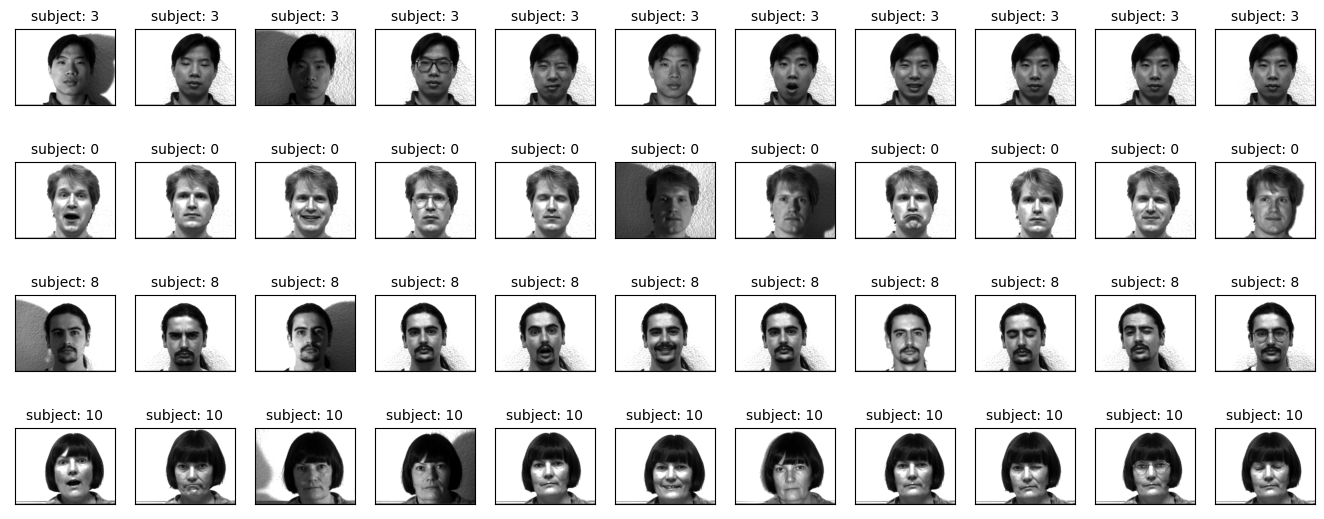

In [3]:
yalefaces.plot_subset(X, y, subjects=[3,0,8,10], num_samples=11)

## Dataset: analysis and pre-processing

### Image size and format

In [4]:
randomface = X[0]
yalefaces.plot_face(randomface)

### Pixel importance from the Chi-squared score

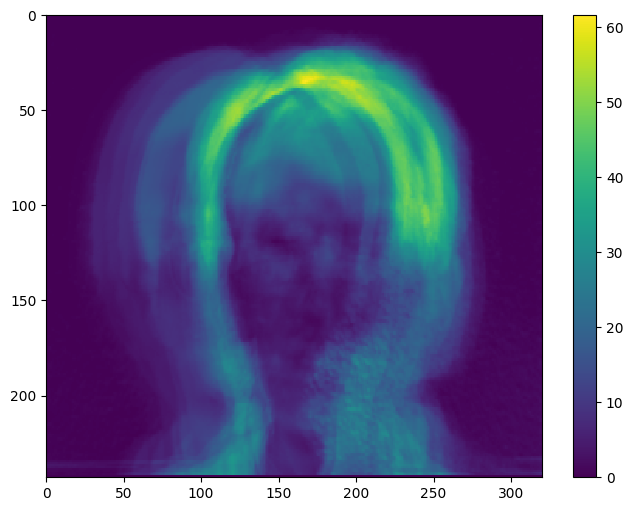

In [6]:
yalefaces.plot_pixel_importance(X, y)

### Image compression using Principal Component Analysis (PCA)
#### Compute eigenfaces using PCA

In [7]:
from sklearn.decomposition import PCA

num_faces, num_pixels = X.shape
num_principal_components = int(num_faces)

pca = PCA(n_components=num_principal_components)
pca.fit(X)

print(f"PCA generated {num_principal_components} eigenfaces of size {yalefaces.SHAPE}.")

PCA generated 165 eigenfaces of size (243, 320).


#### Plot eigenfaces (head, middle and tail)

<Figure size 640x480 with 0 Axes>

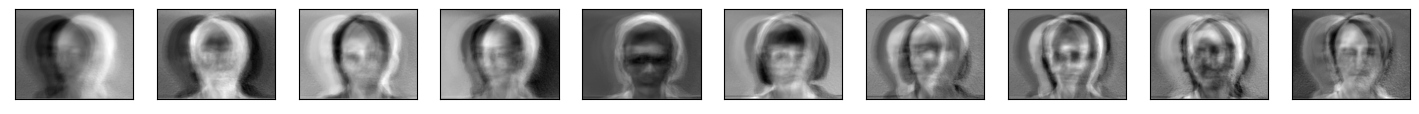

<Figure size 640x480 with 0 Axes>

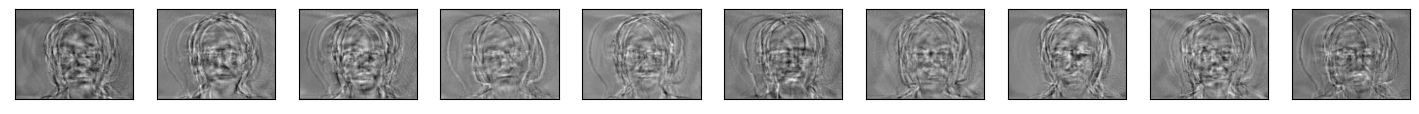

<Figure size 640x480 with 0 Axes>

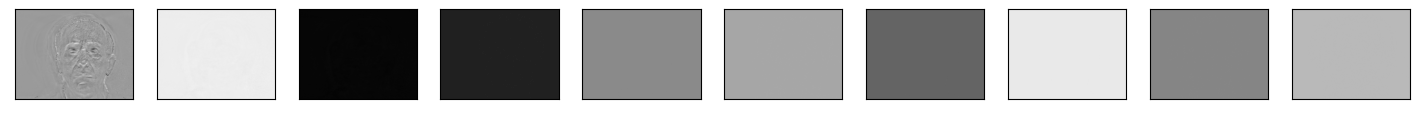

In [8]:
yalefaces.plot_eigenfaces(pca.components_[0:10])
yalefaces.plot_eigenfaces(pca.components_[80:90])
yalefaces.plot_eigenfaces(pca.components_[154:164])

#### Compress images using eigenfaces

In [9]:
X_compressed = pca.transform(X)

#### Compare original and compressed

<Figure size 640x480 with 0 Axes>

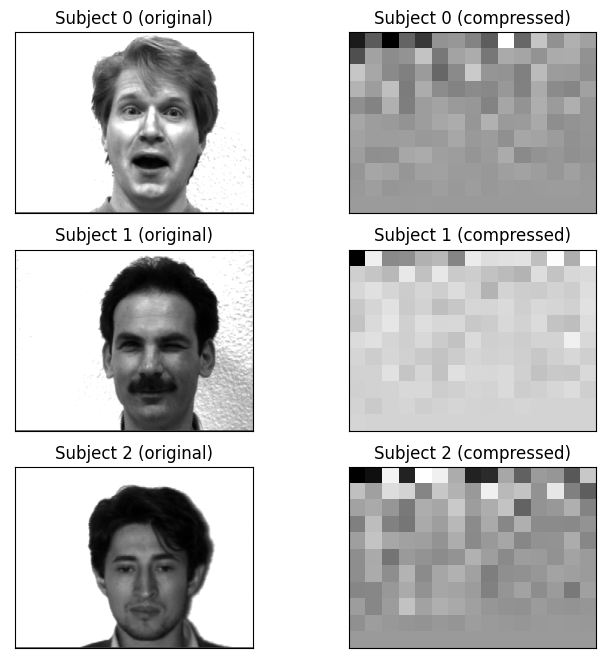

In [10]:
yalefaces.plot_compressed(X, X_compressed, y)

## Train MLP
### Use GPU if NVIDIA CUDA is available

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


### Create train and test datasets

In [12]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

X_train_compressed, X_test_compressed, y_train_compressed, y_test_compressed = train_test_split(X_compressed, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

X_train = torch.Tensor(X_train_compressed)
y_train = torch.LongTensor(y_train_compressed)
train_dataset = TensorDataset(X_train, y_train)

X_test = torch.Tensor(X_test_compressed)
y_test = torch.LongTensor(y_test_compressed)
test_dataset = TensorDataset(X_test, y_test)

### Build a Multilayer Perceptron

In [13]:
from src.models.mlp import MLP
import torch.nn as nn

model = MLP(in_dim=165, out_dim=15, hidden_sizes=[96, 48], activation=nn.ReLU)
model = model.to(device)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)

In [15]:
import torch.nn.functional as F

def train(model, device, train_loader, optimizer, loss_fn=F.cross_entropy):
    model.train()

    epoch_loss = 0
    n_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        # prepare
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # compute
        output = model(data)
        loss = loss_fn(output, target)

        # record
        epoch_loss += loss.item()
        n_samples += output.size(0)

        # adjust
        loss.backward()
        optimizer.step()

    return epoch_loss, n_samples

In [16]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [17]:
def test(model, device, test_loader):
    with torch.no_grad():
        model.train(False)
        num_correct = 0
        num_samples = 0

        for batch_idx, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)

            scores = model.forward(x)
            _, y_out = scores.max(1)
            
            num_correct += (y_out == y).sum()
            num_samples += y_out.size(0)
        
        acc = float(num_correct) / float(num_samples)
    return acc

In [18]:
import numpy as np
from torch.utils.data import DataLoader

train_accs= []
train_losses = []

for epoch in range(200):
    # train
    train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)
    err, n_train_samples = train(model, device, train_data, optimizer)
    loss = float(err)/float(n_train_samples)
    train_losses.append(loss)
    
    # evaluate
    acc = test(model, device, train_data)
    train_accs.append(acc)
    
    # log
    print(f"\nEpoch: {epoch}\nLoss: {loss}\nAcc: {acc * 100:.2f}")



Epoch: 0
Loss: 0.05823511427099055
Acc: 84.85

Epoch: 1
Loss: 0.024180339141325516
Acc: 89.39

Epoch: 2
Loss: 0.00682780925523151
Acc: 93.94

Epoch: 3
Loss: 0.003412597699824608
Acc: 96.97

Epoch: 4
Loss: 0.0015381215983352652
Acc: 100.00

Epoch: 5
Loss: 0.0001872974319143616
Acc: 100.00

Epoch: 6
Loss: 0.00010998928866518492
Acc: 100.00

Epoch: 7
Loss: 0.00015397347460472673
Acc: 100.00

Epoch: 8
Loss: 7.571428784903026e-05
Acc: 100.00

Epoch: 9
Loss: 5.341215397823941e-05
Acc: 100.00

Epoch: 10
Loss: 1.2276601286099652e-05
Acc: 100.00

Epoch: 11
Loss: 2.7845684543894038e-05
Acc: 100.00

Epoch: 12
Loss: 1.4355389077646771e-05
Acc: 100.00

Epoch: 13
Loss: 4.952479464532878e-06
Acc: 100.00

Epoch: 14
Loss: 2.7595391533065015e-06
Acc: 100.00

Epoch: 15
Loss: 1.9208081484424784e-06
Acc: 100.00

Epoch: 16
Loss: 1.4731300035981059e-06
Acc: 100.00

Epoch: 17
Loss: 1.293190590248824e-06
Acc: 100.00

Epoch: 18
Loss: 1.575125762346116e-06
Acc: 100.00

Epoch: 19
Loss: 8.457597332243026e-07
Acc:

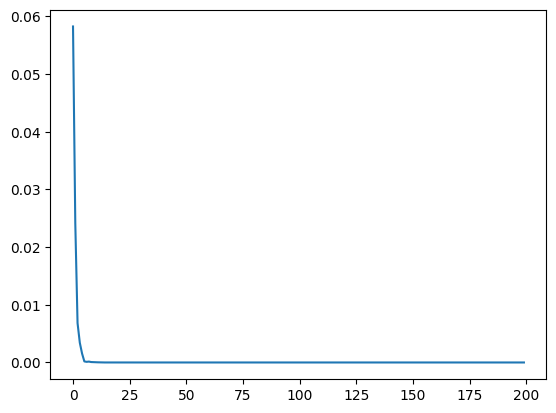

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses)

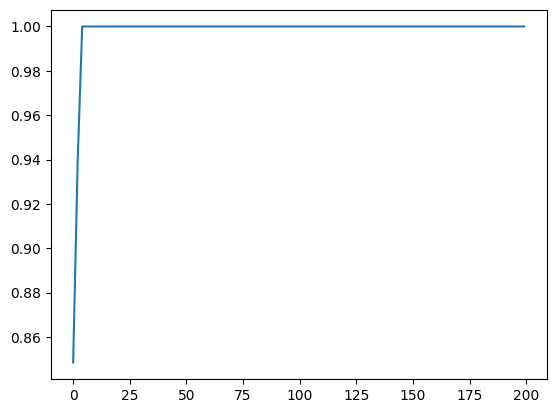

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_accs)

In [21]:
test_data = DataLoader(test_dataset, batch_size=len(test_dataset))
acc = test(model, device, test_data)
print(f"Test accuracy: {acc * 100:.2f}")


Test accuracy: 81.82
